In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import re

plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

In [10]:
path1 = r'附件1.xlsx'
path2 = r'附件2.xlsx'

df_agriarea = pd.read_excel(path1, sheet_name='乡村的现有耕地')
df_agrikind = pd.read_excel(path1, sheet_name='乡村种植的农作物')
df_agrinum = pd.read_excel(path2, sheet_name='2023年的农作物种植情况')
df_agrisell = pd.read_excel(path2, sheet_name='2023年统计的相关数据')
# sheet_names = pd.ExcelFile(path2).sheet_names
# print(sheet_names)
for i in df_agrisell["作物名称"].dropna():
    i.replace(' ', '')
for i in df_agrikind["作物名称"].dropna():
    i.replace(' ', '')
for i in df_agrinum["作物名称"].dropna():
    i.replace(' ', '')
df_agriarea = df_agriarea.drop(columns=['说明 '])
df_agrikind = df_agrikind.drop(columns=['说明'])
df_agrikind = df_agrikind.drop(columns=['种植耕地'])
df_agrinum.ffill(inplace=True)
df_agrisell.columns, df_agrinum.columns

(Index(['序号', '作物编号', '作物名称', '地块类型', '种植季次', '亩产量/斤', '种植成本/(元/亩)',
        '销售单价/(元/斤)'],
       dtype='object'),
 Index(['种植地块', '作物编号', '作物名称', '作物类型', '种植面积/亩', '种植季次'], dtype='object'))

### 合并四个表


In [11]:
df_agriarea.columns = ['种植地块', '地块类型', '地块面积/亩']

df_merge1 = pd.merge(df_agrinum, df_agriarea, on='种植地块', how='left')

df_merge = pd.merge(df_agrinum, df_agrisell, on=['作物编号'], how='left') 
df_merge.drop(columns=['种植季次_y','作物名称_y','序号'], inplace=True)

...
# 1-1


### 处理数据


In [12]:
price = df_merge['销售单价/(元/斤)']
beans = df_merge['作物类型']
is_beans = []
price_min = []
price_max = []
# 找到价格区间
for i in price:
    min_price = float(i.split('-')[0])
    max_price = float(i.split('-')[1])
    price_min.append(min_price)
    price_max.append(max_price)
# 找到豆类
for i in beans:
    if len(i) == 6:
        # print("添加了一个豆类")
        is_beans.append(1)
    else:
        is_beans.append(0)

df_merge['销售单价_min'] = price_min
df_merge['销售单价_max'] = price_max
df_merge['是否豆类'] = is_beans
print(df_merge.columns)
df_merge['总产量'] = df_merge['亩产量/斤'] * df_merge['种植面积/亩']
df_merge['总成本'] = df_merge['种植面积/亩'] * df_merge['种植成本/(元/亩)']
df_merge['总收入'] = df_merge['总产量'] * (df_merge['销售单价_min'] + df_merge['销售单价_max']) / 2
df_merge['销售单价'] = (df_merge['销售单价_min'] + df_merge['销售单价_max']) / 2
df_merge['总利润'] = df_merge['总收入'] - df_merge['总成本']
df_merge1 = df_merge
df_merge['亩利润'] = df_merge['总利润'] / df_merge['种植面积/亩']
df_merge['总利润率'] = df_merge['总利润'] / df_merge['总成本']
df_merge.to_excel('merge.xlsx', index=False)


Index(['种植地块', '作物编号', '作物名称_x', '作物类型', '种植面积/亩', '种植季次_x', '地块类型', '亩产量/斤',
       '种植成本/(元/亩)', '销售单价/(元/斤)', '销售单价_min', '销售单价_max', '是否豆类'],
      dtype='object')


PermissionError: [Errno 13] Permission denied: 'merge.xlsx'

### 各作物利润

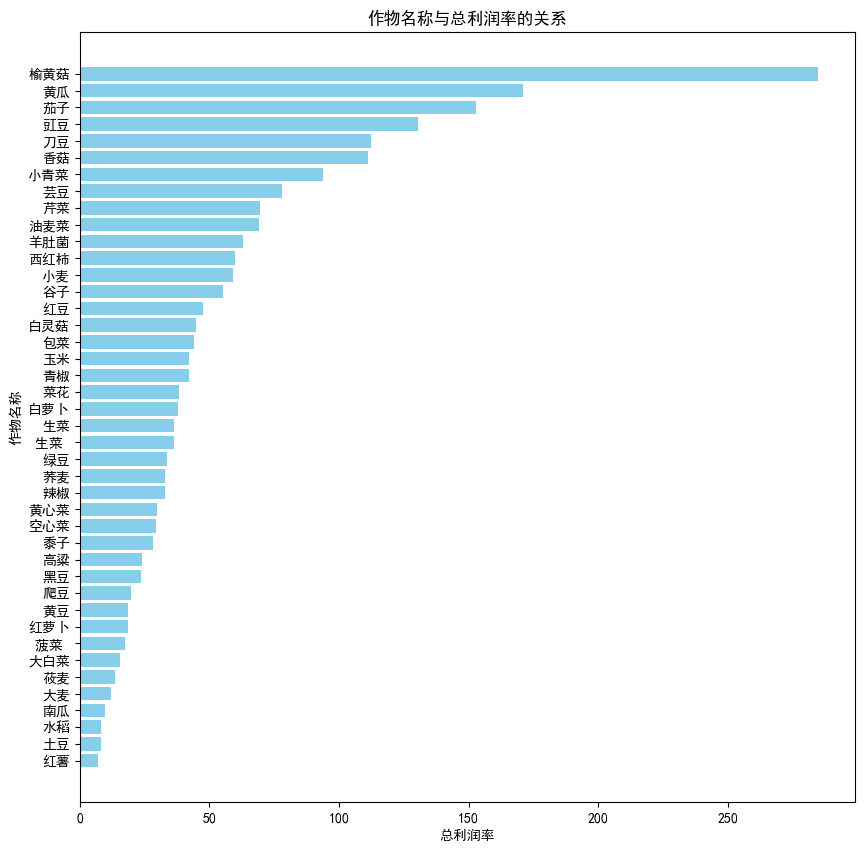

作物名称_x
红薯       7.237500
土豆       8.250000
水稻       8.294118
南瓜       9.825000
大麦      12.000000
莜麦      13.500000
大白菜     15.750000
菠菜      17.677778
红萝卜     18.500000
黄豆      18.787500
爬豆      19.853571
黑豆      23.718750
高粱      24.000000
黍子      28.250000
空心菜     29.575610
黄心菜     29.653636
辣椒      32.729487
荞麦      33.000000
绿豆      33.800000
生菜      36.464489
生菜      36.464489
白萝卜     38.000000
菜花      38.191667
青椒      42.190909
玉米      42.300000
包菜      43.913480
白灵菇     45.000000
红豆      47.742857
谷子      55.125000
小麦      58.933333
西红柿     59.948864
羊肚菌     63.000000
油麦菜     69.170455
芹菜      69.444444
芸豆      77.863636
小青菜     93.872727
香菇     111.000000
刀豆     112.500000
豇豆     130.545455
茄子     152.800000
黄瓜     170.840125
榆黄菇    284.500000
Name: 总利润率, dtype: float64

In [ ]:
grouped = df_merge1.groupby('作物名称_x')['总利润率'].sum()
sorted_grouped = grouped.sort_values(ascending=True)
# 绘制条形图
plt.figure(figsize=(10, 10))
plt.barh(sorted_grouped.index, sorted_grouped.values, color='skyblue')
# 设置图表标题和标签
plt.title('作物名称与总利润率的关系')
plt.xlabel('总利润率')
plt.ylabel('作物名称')

# 显示图表
plt.show()

sorted_grouped

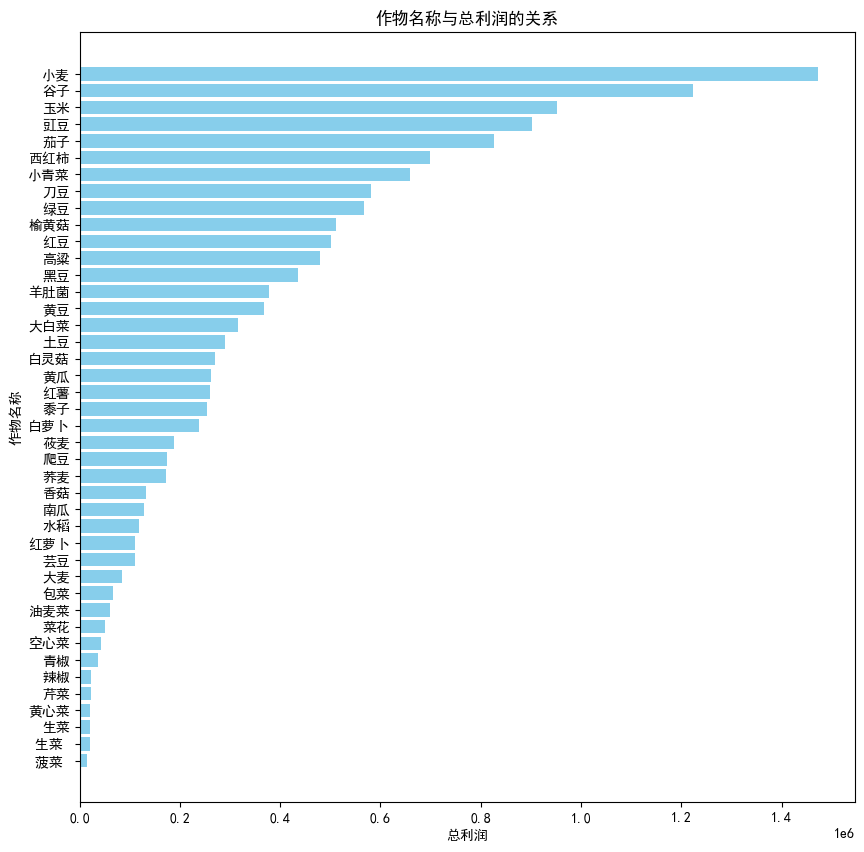

作物名称_x
菠菜       14160.00
生菜       21097.50
生菜       21097.50
黄心菜      21423.00
芹菜       22200.00
辣椒       22956.00
青椒       36819.00
空心菜      43140.00
菜花       49689.00
油麦菜      60030.00
包菜       67527.00
大麦       84000.00
芸豆      109476.00
红萝卜     111000.00
水稻      118440.00
南瓜      127725.00
香菇      133200.00
荞麦      173250.00
爬豆      173718.75
莜麦      189000.00
白萝卜     237500.00
黍子      254250.00
红薯      260550.00
黄瓜      262935.00
白灵菇     270000.00
土豆      290400.00
大白菜     315000.00
黄豆      368235.00
羊肚菌     378000.00
黑豆      436425.00
高粱      480000.00
红豆      501300.00
榆黄菇     512100.00
绿豆      567840.00
刀豆      580800.00
小青菜     658796.00
西红柿     699704.00
茄子      825792.00
豇豆      902464.00
玉米      951750.00
谷子     1223775.00
小麦     1471860.00
Name: 总利润, dtype: float64

In [ ]:
grouped = df_merge1.groupby('作物名称_x')['总利润'].sum()
sorted_grouped = grouped.sort_values(ascending=True)
# 绘制条形图
plt.figure(figsize=(10, 10))
plt.barh(sorted_grouped.index, sorted_grouped.values, color='skyblue')
# 设置图表标题和标签
plt.title('作物名称与总利润的关系')
plt.xlabel('总利润')
plt.ylabel('作物名称')

# 显示图表
plt.show()

sorted_grouped

### 耕地的数量分布

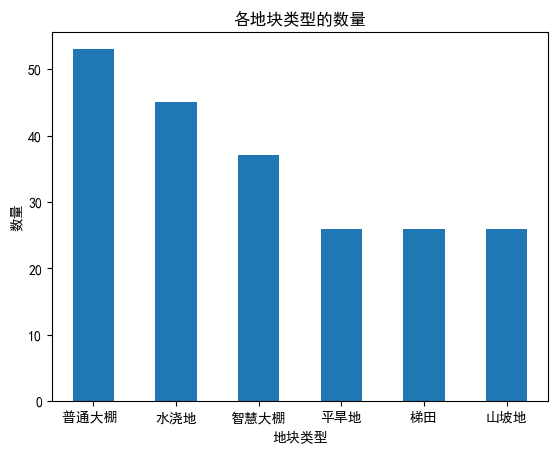

In [ ]:
import matplotlib.pyplot as plt

# 计算每种地块类型的数量
plot_type_counts = df_merge['地块类型'].value_counts()

# 绘制柱形图
plot_type_counts.plot(kind='bar')

plt.ylabel('数量')
plt.title('各地块类型的数量')
plt.xticks(rotation='horizontal')
plt.show()

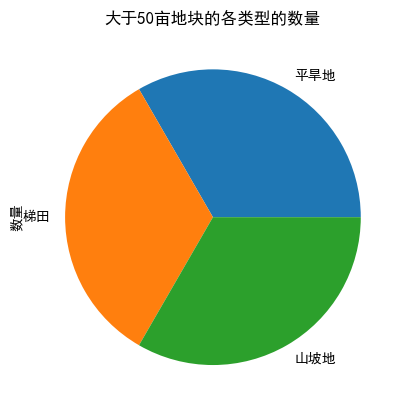

In [ ]:
import matplotlib.pyplot as plt

# 筛选出大于50亩的地块
large_plots = df_merge[df_merge['种植面积/亩'] > 50]

# 计算每种地块类型的数量
plot_type_counts = large_plots['地块类型'].value_counts()

# 绘制柱形图
plot_type_counts.plot(kind='pie')
plt.ylabel('数量')
plt.title('大于50亩地块的各类型的数量')
plt.xticks(rotation='horizontal')  # 添加这行代码来显示 x 轴的标签
plt.show()

### 种类与价格之间的可视化

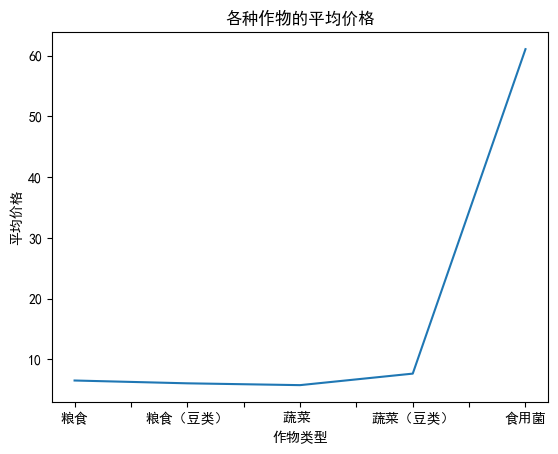

In [ ]:
import matplotlib.pyplot as plt

# 对数据按照 '种类' 进行分组，并计算每种作物的平均价格
average_prices = df_merge.groupby('作物类型')['销售单价'].mean()

# 绘制折线图
average_prices.plot(kind='line')
plt.ylabel('平均价格')
plt.title('各种作物的平均价格')
plt.xticks(rotation='horizontal')  # 添加这行代码来显示 x 轴的标签
plt.show()

### 决策变量


In [ ]:
# 平旱地、梯田种植作物的种类
K_a = df_agrikind.iloc[0:15, 1]
# 水浇地第一季种植作物的种类
K_b = df_agrikind.iloc[15:34, 1]
# 水浇地第二季种植作物的种类
K_bb = df_agrikind.iloc[34:37, 1] 
# 普通大棚第一季种植作物的种类
K_c = df_agrikind.iloc[16:34, 1]

# 普通大棚第二季种植作物的种类
K_cc = df_agrikind.iloc[37:41, 1]
# 智慧大棚第一季种植作物的种类
K_d = df_agrikind.iloc[16:34, 1]
# 智慧大棚第二季种植作物的种类
K_dd = df_agrikind.iloc[16:34, 1]
# 平旱地、梯田的编号
P_a = df_agriarea.iloc[0:26, 0]
# 水浇地的编号
P_b = df_agriarea.iloc[26:34, 0]
# 普通大棚的编号
P_c = df_agriarea.iloc[34:50, 0]
# 智慧大棚的编号
P_d = df_agriarea.iloc[50:54, 0]


# 平旱地、梯田种植情况
a = np.zeros(shape=(26, 15, 8))
# 水浇地第一季种植情况
b = np.zeros(shape=(8, 19, 8))
# 水浇地第二季种植情况
bb = np.zeros(shape=(8, 3, 8))
# 普通大棚第一季种植情况
c = np.zeros(shape=(16, 18, 8))
# 普通大棚第二季种植情况
cc = np.zeros(shape=(16, 4, 8))
# 智慧大棚第一季种植情况
d = np.zeros(shape=(4, 18, 8))
# 智慧大棚第二季种植情况
dd = np.zeros(shape=(4, 18, 8))

for i in range(26):
    df_range = df_merge[(df_merge['地块类型'] == '平旱地') | (df_merge['地块类型'] == '山坡地') | (df_merge['地块类型'] == '梯田')]
    for k in range(len(df_range)):
        if df_range.iloc[k, 0] == P_a.iloc[i]:
            # print(f"这{df_range.iloc[k, 0]}种了")
            for j in range(15): 
                if df_range.iloc[k, 2] == K_a.iloc[j]:
                    # print(f"在这{df_range.iloc[k, 0]}种了{K_a.iloc[j]}")
                    a[i, j, 0] = 1
           
for i in range(8):
    df_range = df_merge[(df_merge['地块类型'] == '水浇地') & ((df_merge['种植季次_x'] == '第一季') | (df_merge['种植季次_x'] == '单季'))]
    for k in range(len(df_range)):
        if df_range.iloc[k, 0] == P_b.iloc[i]:
            # print(f"这{df_range.iloc[k, 0]}种了")
            for j in range(19): 
                if df_range.iloc[k, 2] == K_b.iloc[j]:
                    # print(f"在这{df_range.iloc[k, 0]}种了{K_b.iloc[j]}")
                    b[i, j, 0] = 1

for i in range(8):
    df_range = df_merge[(df_merge['地块类型'] == '水浇地') & (df_merge['种植季次_x'] == '第二季') | (df_merge['种植季次_x'] == '单季')]
    for k in range(len(df_range)):
        if df_range.iloc[k, 0] == P_b.iloc[i]:
            # print(f"这{df_range.iloc[k, 0]}种了")
            for j in range(3): 
                if df_range.iloc[k, 2] == K_bb.iloc[j]:
                    # print(f"在这{df_range.iloc[k, 0]}种了{K_bb.iloc[j]}")
                    bb[i, j, 0] = 1

for i in range(16):
    df_range = df_merge[(df_merge['地块类型'] == '普通大棚 ') & (df_merge['种植季次_x'] == '第一季')]
    for k in range(len(df_range)):
        if df_range.iloc[k, 0] == P_c.iloc[i]:
            # print(f"这{df_range.iloc[k, 0]}种了")
            for j in range(18): 
                if df_range.iloc[k, 2] == K_c.iloc[j]:
                    # print(f"在这{df_range.iloc[k, 0]}种了{K_c.iloc[j]}")
                    c[i, j, 0] = 1

for i in range(16):
    df_range = df_merge[(df_merge['地块类型'] == '普通大棚 ') & (df_merge['种植季次_x'] == '第二季')]
    for k in range(len(df_range)):
        if df_range.iloc[k, 0] == P_c.iloc[i]:
            # print(f"这{df_range.iloc[k, 0]}种了")
            for j in range(4): 
                if df_range.iloc[k, 2] == K_cc.iloc[j]:
                    # print(f"在这{df_range.iloc[k, 0]}种了{K_cc.iloc[j]}")
                    cc[i, j, 0] = 1

for i in range(4):
    df_range = df_merge[(df_merge['地块类型'] == '智慧大棚') & (df_merge['种植季次_x'] == '第一季')]
    for k in range(len(df_range)):
        if df_range.iloc[k, 0] == P_d.iloc[i]:
            # print(f"这{df_range.iloc[k, 0]}种了")
            for j in range(18): 
                if df_range.iloc[k, 2] == K_d.iloc[j]:
                    # print(f"在这{df_range.iloc[k, 0]}种了{K_d.iloc[j]}")
                    d[i, j, 0] = 1
             

for i in range(4):
    df_range = df_merge[(df_merge['地块类型'] == '智慧大棚') & (df_merge['种植季次_x'] == '第二季')]
    for k in range(len(df_range)):
        if df_range.iloc[k, 0] == P_d.iloc[i]:
            # print(f"这{df_range.iloc[k, 0]}种了")
            for j in range(18): 
                if df_range.iloc[k, 2] == K_dd.iloc[j]:
                    # print(f"在这{df_range.iloc[k, 0]}种了{K_d.iloc[j]}")
                    dd[i, j, 0] = 1
# df_merge = df_merge.reset_index(drop=True)

Y_merge = df_merge.groupby('作物名称_x')['总产量'].agg('sum')

def calculate_area_and_yield(a, K_a, P_a, year):
    # Ma是在第k年第i块地种植第j种亩产量
    Ma = np.copy(a[:, :, year])
    # A是在第k年第i块地种植第j种地块面积
    A = np.copy(a[:, :, year])
    # Ga是在第k年第i块地种植第j种亩种植成本
    Ga = np.copy(a[:, :, year])
    # B是在第k年第i块地种植第j种作物是否是豆类
    Bn = np.copy(a[:, :, year])
    # Ya是在第k年第i块地种植第j种预测产量
    Ya = np.copy(a[:, :, year])
    for i in range(a.shape[0]):
        for j in range(a.shape[1]): 
            if a[i, j, year] == 1:
                a_kind = K_a.iloc[j]
                p_sign = P_a.iloc[i]
                p_kind = df_agriarea[df_agriarea['种植地块'] == p_sign]['地块类型'].iloc[0]
                ## print(f"在{p_sign}种了{a_kind}")
                Ma[i, j]= df_agrisell[(df_agrisell['地块类型'] == p_kind) & (df_agrisell['作物名称'] == a_kind)]['亩产量/斤'].iloc[0]
                Ga[i, j]= df_agrisell[(df_agrisell['地块类型'] == p_kind) & (df_agrisell['作物名称'] == a_kind)]['种植成本/(元/亩)'].iloc[0]
                A[i, j] = df_agriarea[(df_agriarea['种植地块'] == p_sign)]['地块面积/亩'].iloc[0]
                Bn[i, j] = df_merge[(df_merge['作物名称_x'] == a_kind)]['是否豆类'].iloc[0]
                Ya[i, j] = Y_merge[a_kind] * 0.8
    return Ma, A, Ga, Bn, Ya

Ma, A, Ga, Bna, Ya = calculate_area_and_yield(a, K_a, P_a, 0)

# Mb是在第k年第i块地种植第j种亩产量
Mb, B, Gb, Bnb, Yb = calculate_area_and_yield(b, K_b, P_b, 0)

# Mbb是在第k年第i块地种植第j种亩产量
Mbb, Bb, Gbb, Bnbb, Ybb = calculate_area_and_yield(bb, K_bb, P_b, 0)

# Mc是在第k年第i块地种植第j种亩产量
Mc, C, Gc, Bnc, Yc = calculate_area_and_yield(c, K_c, P_c, 0)

# Mcc是在第k年第i块地种植第j种亩产量
Mcc, Cc, Gcc, Bncc, Ycc = calculate_area_and_yield(cc, K_cc, P_c, 0)

# Md是在第k年第i块地种植第j种亩产量
Md, D, Gd, Bnd, Yd = calculate_area_and_yield(d, K_d, P_d, 0)

# Mdd是在第k年第i块地种植第j种亩产量
Mdd, Dd, Gdd, Bndd, Ydd = calculate_area_and_yield(dd, K_dd, P_d, 0)



In [ ]:
# 将一块地种多种作物的产量情况分割
def split_Q(Q):
    # 创建一个新的空矩阵用于存储分割后的行
    new_Q = []
    # 遍历矩阵的每一行
    for row in Q:
        non_zero_indices = np.nonzero(row)[0]  # 找到非零元素的列索引
        if len(non_zero_indices) > 1:  # 如果一行有多个非零元素
            for idx in non_zero_indices:
                new_row = np.zeros_like(row)  # 创建全零的行
                new_row[idx] = row[idx]  # 将非零元素分配到新行中
                new_Q.append(new_row)  # 将新行添加到新矩阵中
        else:
            new_Q.append(row)  # 如果没有多个非零元素，直接添加到新矩阵中

    # 将列表转换为NumPy数组
    new_Q = np.array(new_Q)
    return new_Q

# QQ = np.vstack((Ma * A, Mb * B, Mbb * Bb, Mc * C, Mcc * Cc, Md * D, Mdd * Dd))
# QQ_sum = np.sum(QQ, axis=1)
# QQ_sum
Qa = Ma * A
Qb = Mb * B 
Qbb = Mbb * Bb
Qc = Mc * C
Qcc = Mcc * Cc
Qd = Md * D
Qdd = Mdd * Dd

# row_suma = np.sum(Qa, axis=1)
# row_sumb = np.sum(Qb, axis=1)
# row_sumbb = np.sum(Qbb, axis=1)
# row_sumc = np.sum(Qc, axis=1)
# row_sumcc = np.sum(Qcc, axis=1)
# row_sumd = np.sum(Qd, axis=1)
# row_sumdd = np.sum(Qdd, axis=1)
# merged = np.vstack((row_suma, row_sumb, row_sumbb, row_sumc, row_sumcc, row_sumd, row_sumdd))

merged_kind = pd.merge(df_agrikind, df_agrisell, on='作物名称', how='left')
merged_kind.dropna()
merged_kind.drop_duplicates(subset='作物名称', keep='first', inplace=True)
merged_kind1 = merged_kind.iloc[:-4, :]
price = merged_kind1['销售单价/(元/斤)']
price_min = []
price_max = []
for i in price:
    min_price = float(i.split('-')[0])
    max_price = float(i.split('-')[1])
    price_min.append(min_price)
    price_max.append(max_price)
merged_kind1['销售单价_min'] = price_min
merged_kind1['销售单价_max'] = price_max
merged_kind1['销售单价'] = (merged_kind1['销售单价_min'] + merged_kind1['销售单价_max']) / 2


Sa = merged_kind1['销售单价'].iloc[0:15]
Sb = merged_kind1['销售单价'].iloc[15:34]
Sbb = merged_kind1['销售单价'].iloc[34:37]
Sc = merged_kind1['销售单价'].iloc[16:34]
Scc = merged_kind1['销售单价'].iloc[37:41]
Sd = merged_kind1['销售单价'].iloc[16:34]
Sdd = merged_kind1['销售单价'].iloc[16:34]

# F是某一年的销售额
Fa = Qa @ Sa
Fb = Qb @ Sb   
Fbb = Qbb @ Sbb
Fc = Qc @ Sc
Fcc = Qcc @ Scc
Fd = Qd @ Sd
Fdd = Qdd @ Sdd

suma = Fa.sum()
sumb = Fb.sum()
sumbb = Fbb.sum()
sumc = Fc.sum()
sumcc = Fcc.sum()
sumd = Fd.sum()
sumdd = Fdd.sum()

sum_all = suma + sumb + sumbb + sumc + sumcc + sumd + sumdd
sum_all * 0.8

C:\Users\Administrator\AppData\Local\Temp\ipykernel_77092\2240516461.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_kind1['销售单价_min'] = price_min
C:\Users\Administrator\AppData\Local\Temp\ipykernel_77092\2240516461.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_kind1['销售单价_max'] = price_max
C:\Users\Administrator\AppData\Local\Temp\ipykernel_77092\2240516461.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

5457805.0

### 蒙特卡洛搜索

In [ ]:
# 约束条件
"""
不能重茬
"""

fanganshua = []
fanganshub = []
fanganshubb = []
fanganshuc = []
fanganshucc = []
fanganshud = []
fanganshudd = []

def generate_matrix_with_one_per_row(rows, cols):
    matrix = np.zeros((rows, cols), dtype=int)  # 生成一个全为0的矩阵
    for i in range(rows):
        j = np.random.randint(0, cols)  # 在每行随机选择一个位置
        matrix[i, j] = 1  # 将该位置置为1
    return matrix

def generate_matrix_with_condition(fanganshu, rows, cols, last_year_matrix):
    for each_random in range(10000):
    # 生成一个 5x5 的随机矩阵，每行只有一个1
        matrix = generate_matrix_with_one_per_row(rows, cols)
        fanganshu.append(matrix)

    count = 0
    to_remove = []  # 用于存储需要移除的方案

    # 标记要移除的方案
    for each_fangan in fanganshu:
        flag = 0
        count += 1
        jianyan = each_fangan + last_year_matrix[:, :, 0]
      
        
        for i in range(rows):
            if flag == 1:
                break
            for j in range(cols):
                if jianyan[i, j] > 1:
                    to_remove.append(each_fangan)  # 标记要移除的方案
                    flag = 1
                    break

    # 使用 `np.array_equal` 删除标记的方案
    fanganshu = [fangan for fangan in fanganshu if not any(np.array_equal(fangan, remove) for remove in to_remove)]

# # 打印方案数
# print(len(fanganshu))
generate_matrix_with_condition(fanganshua, 26, 15, a)
generate_matrix_with_condition(fanganshub, 8, 19, b)
generate_matrix_with_condition(fanganshubb, 8, 3, bb)
generate_matrix_with_condition(fanganshuc, 16, 18, c)
generate_matrix_with_condition(fanganshucc, 16, 4, cc)
generate_matrix_with_condition(fanganshud, 4, 18, d)
generate_matrix_with_condition(fanganshudd, 4, 18, dd)



In [ ]:

def calculate_profit(Ma_a, A_a, Ga_a, scheme, Sa, Ya):
    Q = scheme * Ma_a * A_a
    for i in range(Q.shape[0]):
        for j in range(Q.shape[1]):
            if Q[i, j] > Ya[i, j]:
                Q[i, j] = Ya[i, j]
    F = Q @ Sa
    sum = F.sum()
    profit = sum - (Ga_a * A_a).sum()
    return profit
    

def calculate_profit2(Ma_a, A_a, Ga_a, scheme, Sa, Ya):
    Q = scheme * Ma_a * A_a
    for i in range(Q.shape[0]):
        for j in range(Q.shape[1]):
            if Q[i, j] > Ya[i, j]:
                Q[i, j] = (Q[i, j] - Ya[i, j]) * 0.4 + Ya[i, j]
    F = Q @ Sa
    sum = F.sum()
    profit = sum - (Ga_a * A_a).sum()
    return profit
    


In [ ]:
"""
取2024年a最优方案
"""
maxa = 0
maxb = 0
maxbb = 0
maxc = 0
maxcc = 0
maxd = 0
maxdd = 0
max_profit = -np.inf  # 初始化最大利润为负无穷
best_fangan = None  # 初始化最佳方案为 None
best_matrix = None  # 初始化最佳矩阵为 None


for each_fangan in fanganshua:
    a[:, :, 1] = each_fangan
    Ma24 ,A24, G24, Bn24, Ya24 = calculate_area_and_yield(a, K_a, P_a, 1)
    profit = calculate_profit(Ma24, A24, G24, each_fangan, Sa, Ya24)
    if profit > max_profit:  # 如果当前方案的利润大于已知的最大利润
        max_profit = profit  # 更新最大利润
        best_fangan = each_fangan  # 保存最佳方案
        best_matrix = a.copy()  # 保存最佳矩阵

for each_fangan in fanganshub:
    b[:, :, 1] = each_fangan
    Mb24 ,B24, Gb24, Bnb24, Yb24 = calculate_area_and_yield(b, K_b, P_b, 1)
    profit = calculate_profit(Mb24, B24, Gb24, each_fangan, Sb, Yb24)
    if profit > max_profit:  # 如果当前方案的利润大于已知的最大利润
        max_profit = profit  # 更新最大利润
        best_fangan = each_fangan  # 保存最佳方案
        best_matrix = b.copy()  # 保存最佳矩阵
    
for each_fangan in fanganshubb:
    bb[:, :, 1] = each_fangan
    Mbb24 ,Bb24, Gbb24, Bnbb24, Ybb24 = calculate_area_and_yield(bb, K_bb, P_b, 1)
    profit = calculate_profit(Mbb24, Bb24, Gbb24, each_fangan, Sbb, Ybb24)
    if profit > max_profit:  # 如果当前方案的利润大于已知的最大利润
        max_profit = profit
        best_fangan = each_fangan
        best_matrix = bb.copy()

for each_fangan in fanganshuc:
    c[:, :, 1] = each_fangan
    Mc24 ,C24, Gc24, Bnc24, Yc24 = calculate_area_and_yield(c, K_c, P_c, 1)
    profit = calculate_profit(Mc24, C24, Gc24, each_fangan, Sc, Yc24)
    if profit > max_profit:  # 如果当前方案的利润大于已知的最大利润
        max_profit = profit
        best_fangan = each_fangan
        best_matrix = c.copy()
for each_fangan in fanganshucc:
    cc[:, :, 1] = each_fangan
    Mcc24 ,Cc24, Gcc24, Bncc24, Ycc24 = calculate_area_and_yield(cc, K_cc, P_c, 1)
    profit = calculate_profit(Mcc24, Cc24, Gcc24, each_fangan, Scc, Ycc24)
    if profit > max_profit:  # 如果当前方案的利润大于已知的最大利润
        max_profit = profit
        best_fangan = each_fangan
        best_matrix = cc.copy()
        
for each_fangan in fanganshud:
    d[:, :, 1] = each_fangan
    Md24 ,D24, Gd24, Bnd24, Yd24 = calculate_area_and_yield(d, K_d, P_d, 1)
    profit = calculate_profit(Md24, D24, Gd24, each_fangan, Sd, Yd24)
    if profit > max_profit:  # 如果当前方案的利润大于已知的最大利润
        max_profit = profit
        best_fangan = each_fangan
        best_matrix = d.copy()

for each_fangan in fanganshudd:
    dd[:, :, 1] = each_fangan
    Mdd24 ,Dd24, Gdd24, Bndd24, Ydd24 = calculate_area_and_yield(dd, K_dd, P_d, 1)
    profit = calculate_profit(Mdd24, Dd24, Gdd24, each_fangan, Sdd, Ydd24)
    if profit > max_profit:  # 如果当前方案的利润大于已知的最大利润
        max_profit = profit
        best_fangan = each_fangan
        best_matrix = dd.copy()


sum_all_p = maxa + maxb + maxbb + maxc + maxcc + maxd + maxdd
print(sum_all_p)
result = np.vstack(a[:, :, 1], b[:, :, 1], bb[:, :, 1], c[:, :, 1], cc[:, :, 1], d[:, :, 1], dd[:, :, 1])
print(result)
result.to_excel(r'C:\Users\Administrator\Desktop\2024C\附件3\~$result1_1.xlsx', index=False)

### 1-2

In [ ]:

maxa = 0
maxb = 0
maxbb = 0
maxc = 0
maxcc = 0
maxd = 0
maxdd = 0
def mx(a, b):
    return a if a > b else b
for each_fangan in fanganshua:
    a[:, :, 1] = each_fangan
    Ma24 ,A24, G24, Bn24, Ya24 = calculate_area_and_yield(a, K_a, P_a, 1)
    maxa = mx(calculate_profit2(Ma24, A24, G24, each_fangan, Sa, Ya24), maxa)

for each_fangan in fanganshub:
    b[:, :, 1] = each_fangan
    Mb24 ,B24, Gb24, Bnb24, Yb24 = calculate_area_and_yield(b, K_b, P_b, 1)
    maxb = mx(calculate_profit2(Mb24, B24, Gb24, each_fangan, Sb, Yb24), maxb)

for each_fangan in fanganshubb:
    bb[:, :, 1] = each_fangan
    Mbb24 ,Bb24, Gbb24, Bnbb24, Ybb24 = calculate_area_and_yield(bb, K_bb, P_b, 1)
    maxbb = mx(calculate_profit2(Mbb24, Bb24, Gbb24, each_fangan, Sbb, Ybb24), maxbb)

for each_fangan in fanganshuc:
    c[:, :, 1] = each_fangan
    Mc24 ,C24, Gc24, Bnc24, Yc24 = calculate_area_and_yield(c, K_c, P_c, 1)
    maxc = mx(calculate_profit2(Mc24, C24, Gc24, each_fangan, Sc, Yc24), maxc)

for each_fangan in fanganshucc:
    cc[:, :, 1] = each_fangan
    Mcc24 ,Cc24, Gcc24, Bncc24, Ycc24 = calculate_area_and_yield(cc, K_cc, P_c, 1)
    maxcc = mx(calculate_profit2(Mcc24, Cc24, Gcc24, each_fangan, Scc, Ycc24), maxcc)

for each_fangan in fanganshud:
    d[:, :, 1] = each_fangan
    Md24 ,D24, Gd24, Bnd24, Yd24 = calculate_area_and_yield(d, K_d, P_d, 1)
    maxd = mx(calculate_profit2(Md24, D24, Gd24, each_fangan, Sd, Yd24), maxd)

for each_fangan in fanganshudd:
    dd[:, :, 1] = each_fangan
    Mdd24 ,Dd24, Gdd24, Bndd24, Ydd24 = calculate_area_and_yield(dd, K_dd, P_d, 1)
    maxdd = mx(calculate_profit2(Mdd24, Dd24, Gdd24, each_fangan, Sdd, Ydd24), maxdd)


sum_all_p = maxa + maxb + maxbb + maxc + maxcc + maxd + maxdd
print(sum_all_p)

3367814.5


### 灵敏度分析

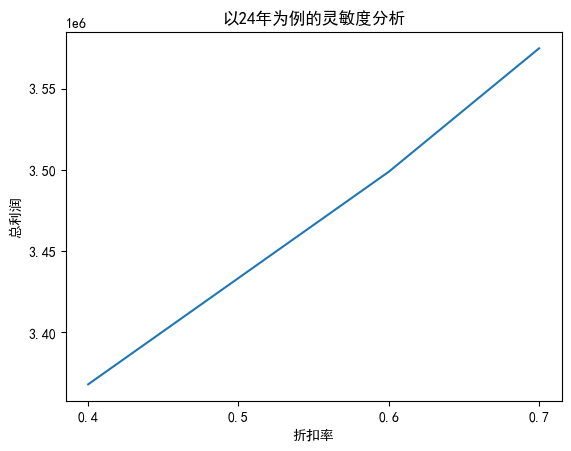

In [ ]:
import matplotlib.pyplot as plt

# 定义数据
delicacy = {'0.4': 3367814.5, '0.5':3433295.0, '0.6':3498775.5, '0.7':3574819.0}

# 绘制折线图
plt.plot(list(delicacy.keys()), list(delicacy.values()))
plt.xlabel('折扣率')
plt.ylabel('总利润')
plt.title('以24年为例的灵敏度分析')
plt.show()

# 2


### 将预测的统计量进行可视化

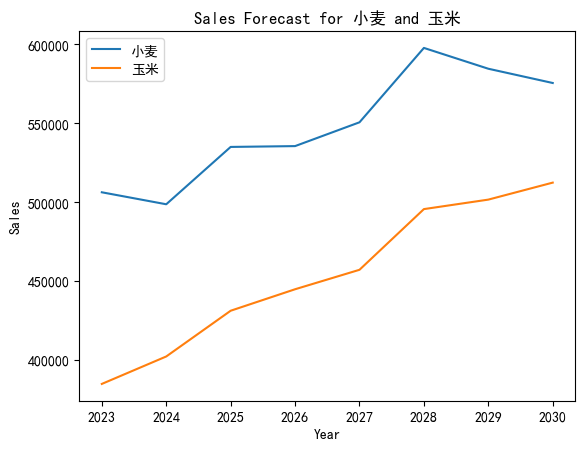

In [ ]:
import random
import pandas as pd
import matplotlib.pyplot as plt

# 2023年的数据
data_2023Q = df_merge.groupby('作物名称_x')['总产量'].agg('sum')  # 基于作物名称_x
data_2023G = df_merge.groupby('作物类型')['总成本'].agg('sum')    # 基于作物类型
data_2023M = df_merge.groupby('作物类型')['亩产量/斤'].agg('sum')  # 基于作物类型
data_2023S = df_merge.groupby('作物类型')['销售单价'].agg('sum')  # 基于作物类型

# 创建空的数据框，并将作物名称作为索引
data_2023 = pd.DataFrame(index=data_2023Q.index)

# 合并2023年的农作物数据
data_2023['sales'] = data_2023Q  # 总产量数据（基于作物名称_x）
data_2023['cost'] = data_2023G.reindex(data_2023Q.index, fill_value=0)  # 总成本数据（基于作物类型），需要对齐索引
data_2023['yield'] = data_2023M.reindex(data_2023Q.index, fill_value=0)  # 亩产量数据（基于作物类型），需要对齐索引
data_2023['price'] = data_2023S.reindex(data_2023Q.index, fill_value=0)  # 销售单价（基于作物类型），需要对齐索引

# 初始化数据列表
data = [data_2023]

# 生成2024到2030年的预期数据
for _ in range(7):
    new_data = data[-1].copy()
    for i, row in new_data.iterrows():
        sales_growth = random.uniform(-0.05, 0.1)  # 销售量增长率的范围
        yield_growth = random.uniform(-0.1, 0.1)   # 亩产量增长率的范围

        if row.name in ['小麦', '玉米']:  # 根据作物名称判断
            price_growth = 0
        elif row.name == '蔬菜':
            price_growth = 0.05
        elif row.name == '蘑菇':
            price_growth = random.uniform(-0.05, -0.01)
        elif row.name == '羊肚菌':
            price_growth = -0.05
        else:
            price_growth = random.uniform(-0.05, 0.05)  # 默认价格增长

        cost_growth = 0.05  # 成本增长率的范围

        new_data.loc[i, 'sales'] *= (1 + sales_growth)
        new_data.loc[i, 'yield'] *= (1 + yield_growth)
        new_data.loc[i, 'price'] *= (1 + price_growth)
        new_data.loc[i, 'cost'] *= (1 + cost_growth)
    
    data.append(new_data)

# 画出小麦和玉米的预期销售量的变化
for crop in ['小麦', '玉米']:
    # 获取每年的销售数据
    sales = [df.loc[crop, 'sales'] if crop in df.index else None for df in data]
    
    # 检查 sales 列表是否为空，确保不访问空数据
    if any(s is not None for s in sales):
        plt.plot(range(2023, 2031), sales, label=crop)
    else:
        print(f"No sales data for {crop}")

plt.legend()
plt.xlabel('Year')
plt.ylabel('Sales')
plt.title('Sales Forecast for 小麦 and 玉米')
plt.show()


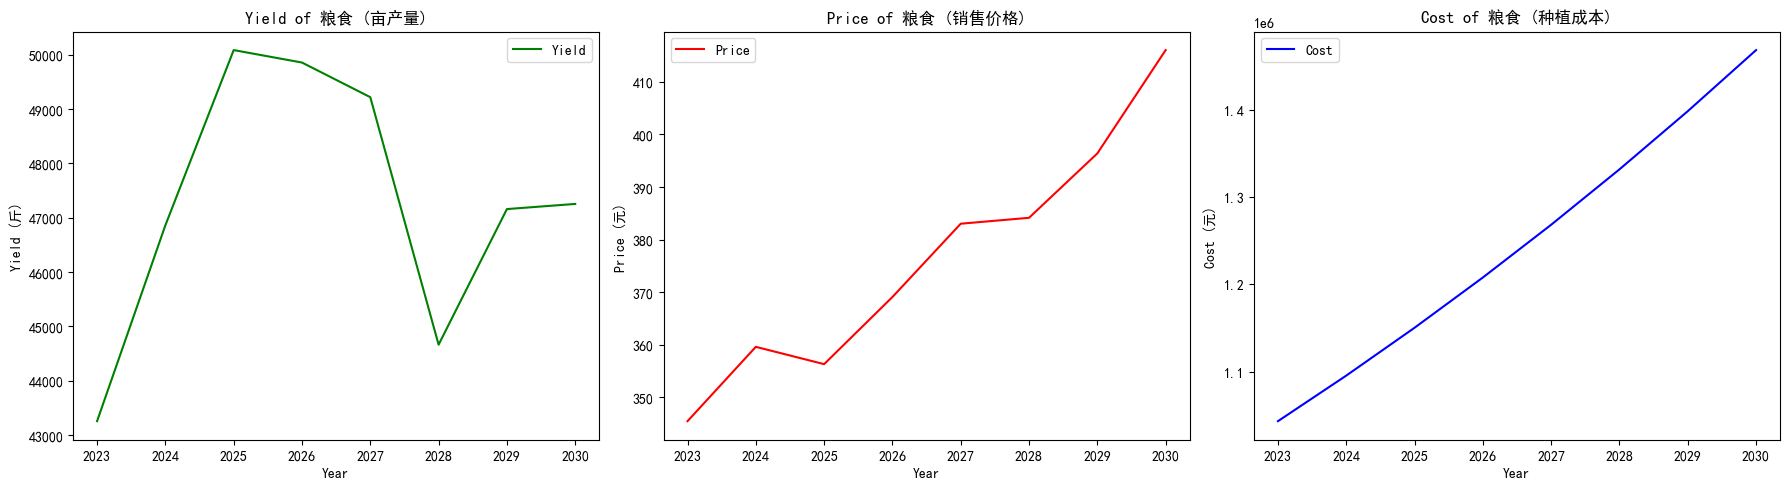

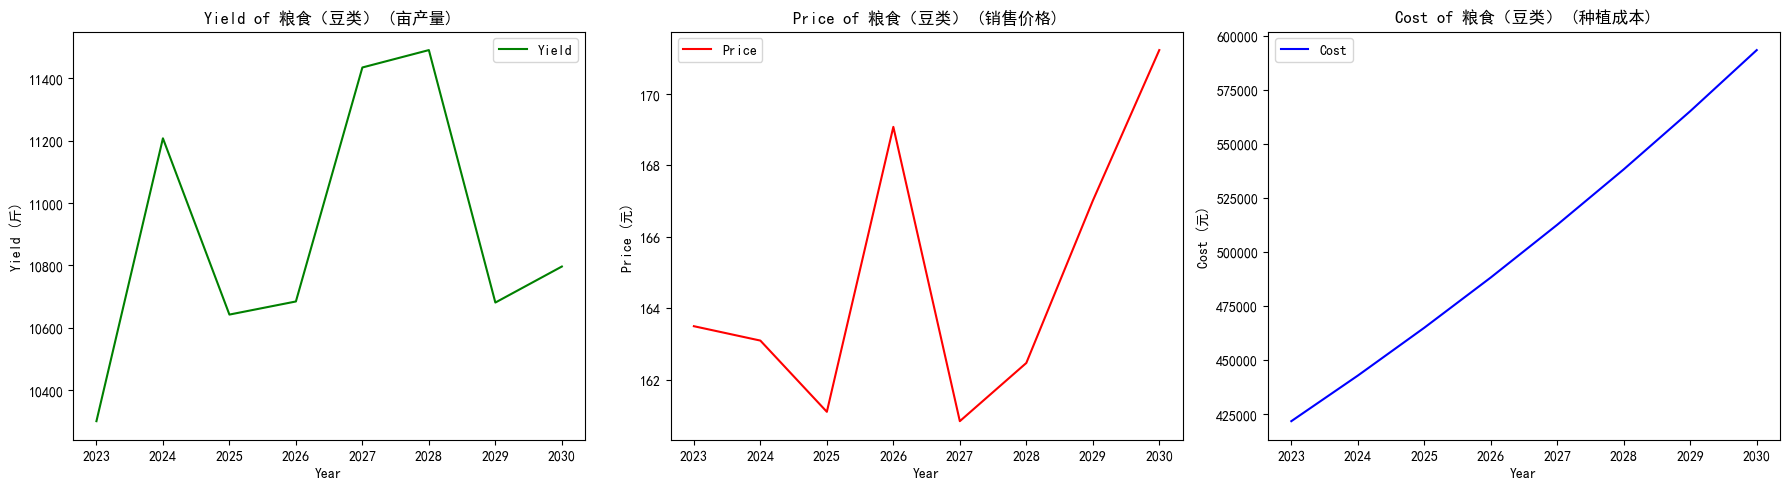

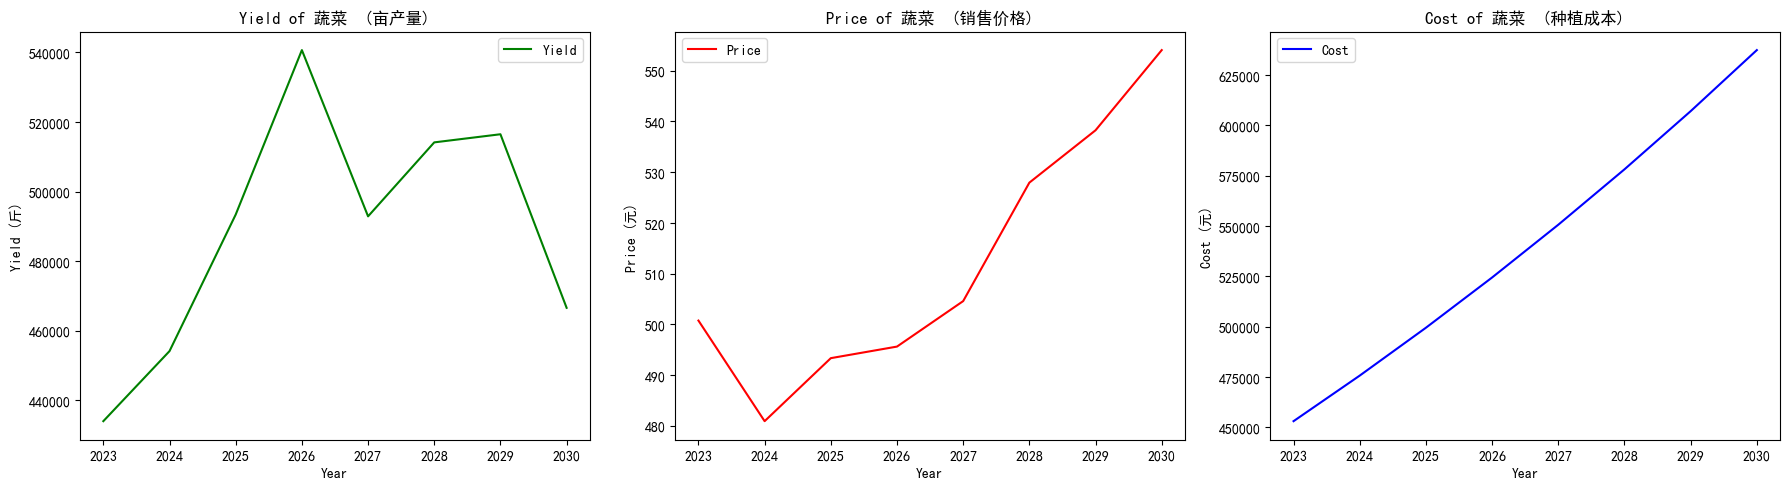

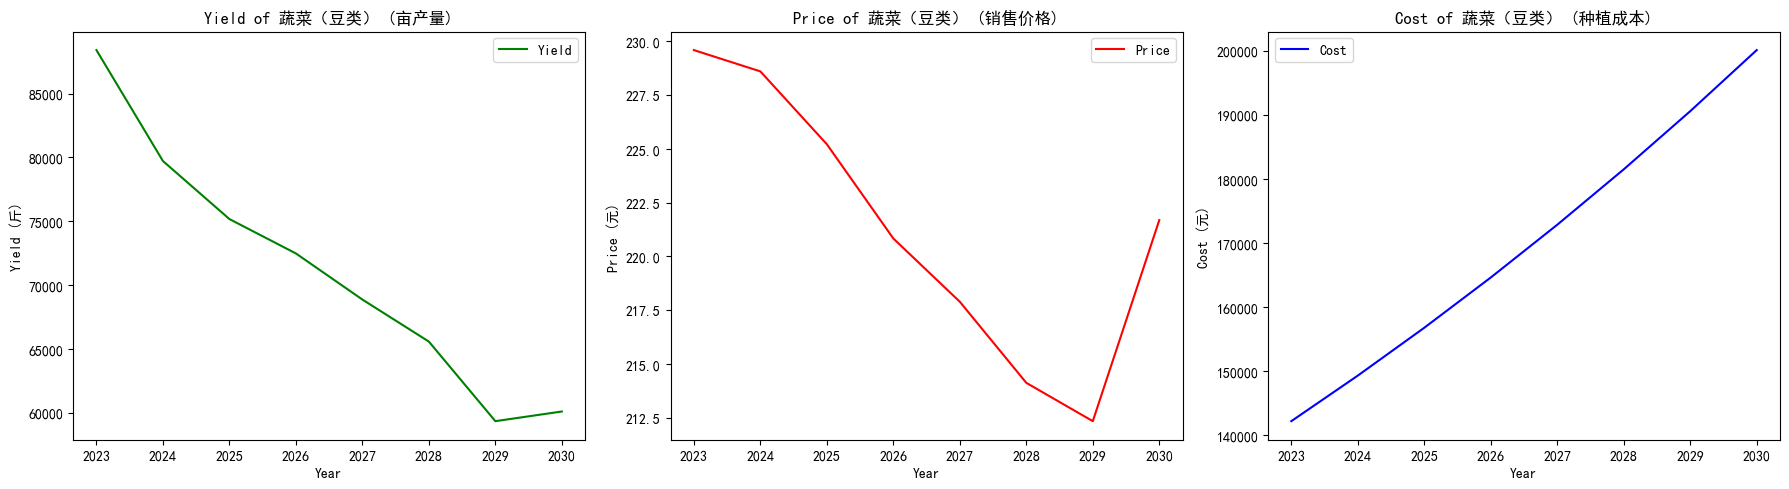

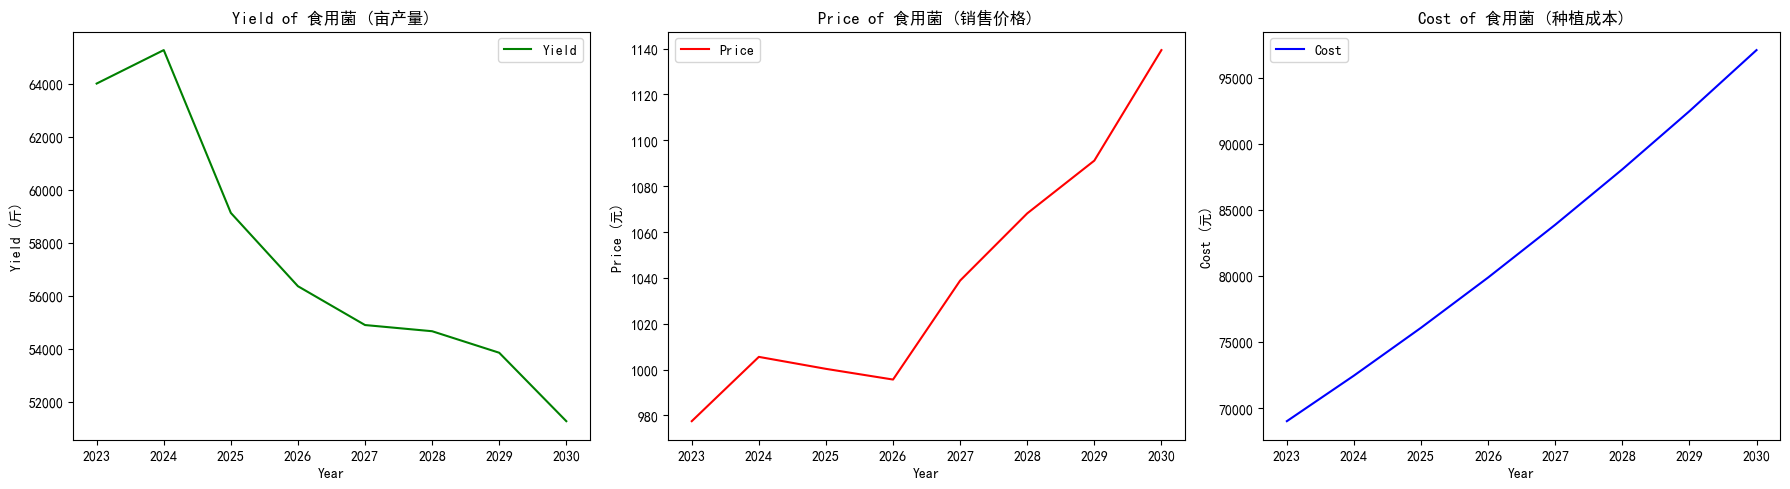

In [ ]:
import random
import pandas as pd
import matplotlib.pyplot as plt

# 2023年的数据
data_2023G = df_merge.groupby('作物类型')['总成本'].agg('sum')  # 基于作物类型
data_2023M = df_merge.groupby('作物类型')['亩产量/斤'].agg('sum')  # 基于作物类型
data_2023S = df_merge.groupby('作物类型')['销售单价'].agg('sum')  # 基于作物类型

# 创建2023年的基础数据框
data_2023 = pd.DataFrame({
    'cost': data_2023G,
    'yield': data_2023M,
    'price': data_2023S
})

# 初始化数据列表
data = [data_2023]

# 生成2024到2030年的预期数据
for _ in range(7):
    new_data = data[-1].copy()
    for crop_type, row in new_data.iterrows():
        # 设置每种作物的增长率
        if crop_type in ['小麦', '玉米']:
            sales_growth = random.uniform(0.05, 0.1)  # 小麦和玉米的销售量增长率介于5%--10%之间
            price_growth = 0  # 粮食类作物价格保持不变
        elif crop_type == '蔬菜':
            sales_growth = random.uniform(-0.05, 0.05)  # 其他作物销售量相对2023年浮动±5%
            price_growth = 0.05  # 蔬菜类销售价格年增长率为5%
        elif crop_type == '食用菌':
            sales_growth = random.uniform(-0.05, 0.05)
            price_growth = random.uniform(-0.01, 0.05)  # 食用菌销售价格年增长率为-1%--5%
        elif crop_type == '羊肚菌':
            sales_growth = random.uniform(-0.05, 0.05)
            price_growth = -0.05  # 羊肚菌销售价格年增长率为-5%
        else:
            sales_growth = random.uniform(-0.05, 0.05)
            price_growth = random.uniform(-0.05, 0.05)

        yield_growth = random.uniform(-0.1, 0.1)  # 每种农作物亩产量每年变化率在±10%间浮动
        cost_growth = 0.05  # 所有农作物种植成本年增长率为5%

        # 更新2024-2030年数据
        new_data.loc[crop_type, 'yield'] *= (1 + yield_growth)
        new_data.loc[crop_type, 'price'] *= (1 + price_growth)
        new_data.loc[crop_type, 'cost'] *= (1 + cost_growth)
    
    # 添加更新后的数据
    data.append(new_data)

# 获取作物类型列表
crop_types = data_2023.index.unique()

# 对每种作物类型进行绘图
for crop_type in crop_types:
    # 获取每年的亩产量、销售价格和成本数据
    yields = [df.loc[crop_type, 'yield'] for df in data]
    prices = [df.loc[crop_type, 'price'] for df in data]
    costs = [df.loc[crop_type, 'cost'] for df in data]

    # 创建一个新的图形
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

    # 绘制亩产量图
    ax1.plot(range(2023, 2031), yields, label='Yield', color='green')
    ax1.set_title(f'Yield of {crop_type} (亩产量)')
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Yield (斤)')
    ax1.legend()

    # 绘制销售价格图
    ax2.plot(range(2023, 2031), prices, label='Price', color='red')
    ax2.set_title(f'Price of {crop_type} (销售价格)')
    ax2.set_xlabel('Year')
    ax2.set_ylabel('Price (元)')
    ax2.legend()

    # 绘制种植成本图
    ax3.plot(range(2023, 2031), costs, label='Cost', color='blue')
    ax3.set_title(f'Cost of {crop_type} (种植成本)')
    ax3.set_xlabel('Year')
    ax3.set_ylabel('Cost (元)')
    ax3.legend()

    # 显示图形
    plt.tight_layout()
    plt.show()


### 目标函数，粒子群模型的主要部分


In [ ]:
from pyswarm import pso
from tqdm import tqdm
# PSO 参数设定
num_particles = 50  # 粒子数量
max_iter = 100  # 最大迭代次数

# Example: 每个矩阵代表一个土地种植决策，三维表示地块数量 x 作物数量 x 年份数量
total_variables = (26+8+8+16+16+4+4) * 19 * 8

# Set lb and ub for decision variables
lb = [0] * total_variables  # 设置为0代表未种植
ub = [1] * total_variables  # 设置为1代表已种植


def calculate_total_profit_with_constraints(solution, num_years=8):
    """
    计算多个年份的总利润，加入约束条件：1. 同一块地不能连续两年种同一种作物。
    2. 三年内必须种一次豆类。
    
    Parameters:
    - solution: 粒子群中的一个种植方案，包含多个年份的种植信息。
    - num_years: 一共有多少年。
    
    Returns:
    - 总利润的负值（适应度函数，目标是最小化负利润，即最大化利润）。
    
    """
    
    combined_land_matrix = solution.reshape((26+8+8+16+16+4+4, -1, num_years))
  
    total_profit = 0
    penalty = 0  # 惩罚项

    # 遍历每一年，分别计算每年的总利润
    for year in range(num_years):
        a_new = combined_land_matrix[:26, :15, :]    # 平旱地、梯田
        b_new = combined_land_matrix[26:34, :19, :]  # 水浇地第一季
        bb_new = combined_land_matrix[34:42, :3, :]  # 水浇地第二季
        c_new = combined_land_matrix[42:58, :18, :]  # 普通大棚第一季
        cc_new = combined_land_matrix[58:74, :4, :]  # 普通大棚第二季
        d_new = combined_land_matrix[74:78, :18, :]  # 智慧大棚第一季
        dd_new = combined_land_matrix[78:82, :18, :] # 智慧大棚第二季

        Ma_a, A_a, Ga_a = calculate_area_and_yield(a_new, K_a, P_a, year)
        Ma_b, A_b, Ga_b = calculate_area_and_yield(b_new, K_b, P_b, year)
        Ma_bb, A_bb, Ga_bb = calculate_area_and_yield(bb_new, K_bb, P_b, year)
        Ma_c, A_c, Ga_c = calculate_area_and_yield(c_new, K_c, P_c, year)
        Ma_cc, A_cc, Ga_cc = calculate_area_and_yield(cc_new, K_cc, P_c, year)
        Ma_d, A_d, Ga_d = calculate_area_and_yield(d_new, K_d, P_d, year)
        Ma_dd, A_dd, Ga_dd = calculate_area_and_yield(dd_new, K_dd, P_d, year)

        profit_for_year = (
            calculate_profit(Ma_a, A_a, Ga_a, a_new[:, :, year], Sa) +
            calculate_profit(Ma_b, A_b, Ga_b, b_new[:, :, year], Sb) +
            calculate_profit(Ma_bb, A_bb, Ga_bb, bb_new[:, :, year], Sbb) +
            calculate_profit(Ma_c, A_c, Ga_c, c_new[:, :, year], Sc) +
            calculate_profit(Ma_cc, A_cc, Ga_cc, cc_new[:, :, year], Scc) +
            calculate_profit(Ma_d, A_d, Ga_d, d_new[:, :, year], Sd) +
            calculate_profit(Ma_dd, A_dd, Ga_dd, dd_new[:, :, year], Sdd)
        )

        total_profit += profit_for_year

    # 约束1：每块地只种一种作物
    for i in range(combined_land_matrix.shape[0]):  # 遍历每块地
        for year in range(num_years):
            if np.sum(combined_land_matrix[i, :, year]) != 1:
                penalty += 1000  # 惩罚值

    # 约束2：同一块地不能连续两年种同一种作物
    for i in range(combined_land_matrix.shape[0]):  # 遍历每块地
        for year in range(1, num_years):
            if np.array_equal(combined_land_matrix[i, :, year], combined_land_matrix[i, :, year - 1]):
                penalty += 1000  # 惩罚值


    # # 约束2：三年内必须种一次豆类 (假设豆类作物在 K_a 中的编号为 "X")
    # bean_index = ...  # 找到豆类作物的索引
    # for i in range(combined_land_matrix.shape[0]):  # 遍历每块地
    #     for year in range(0, num_years - 2):
    #         if bean_index not in combined_land_matrix[i, :, year:year + 3]:
    #             penalty += 500  # 惩罚值

   

# 初始化进度条
pbar = tqdm(total=max_iter, desc="PSO Optimization", unit="iter")

# 定义回调函数更新进度条
def pso_callback(x):
    pbar.update(1)

# 使用粒子群算法进行优化，添加回调
best_solution, best_fitness = pso(calculate_total_profit_with_constraints, lb, ub, swarmsize=num_particles, maxiter=max_iter, callback=pso_callback)

print(f"最优解: {best_solution}")
print(f"最大利润: {-best_fitness}")



Stopping search: Swarm best position change less than 1e-08
最优解: [0.86436097 1.         0.         ... 0.         0.         0.89312432]
最大利润: 170116698.476395


# 3

In [ ]:

import seaborn as sns
import matplotlib.pyplot as plt

# 获取所有的作物类型
crop_types = data_2023G.index
print(data_2023G)
# 创建一个空的 DataFrame 用于存储每种作物类型的总成本
total_costs = pd.DataFrame()

for crop_type in crop_types:
    # 提取每种作物类型的总成本
    total_cost = data_2023G[crop_type]
    total_costs[crop_type] = total_cost

# 计算各种作物类型之间的总成本的 Pearson 相关系数
correlation_matrix = total_costs.corr()

# 绘制热力图
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2g', linewidths=0.5)
plt.title('Pearson Correlation Matrix of Total Costs between Crop Types')
plt.show()

### 利用随机森林得到最优结果

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# 假设你的数据框名为 df
# 选择特征和目标变量
X = df_merge[['成本', '亩产量']]  # 特征
y = df_merge['销售量']  # 目标变量

# 分割数据集为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 初始化随机森林回归模型
model = RandomForestRegressor(n_estimators=100, random_state=42)

# 训练模型
model.fit(X_train, y_train)

# 预测测试集
y_pred = model.predict(X_test)

# 评估模型
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

# 特征重要性
feature_importances = model.feature_importances_
features = X.columns

# 绘制特征重要性
plt.figure(figsize=(10, 6))
plt.barh(features, feature_importances, color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Feature Importance from Random Forest Model')
plt.show()

# 使用模型进行预测
future_data = pd.DataFrame({
    '成本': ['预测的成本值1', '预测的成本值2'],
    '亩产量': ['预测的亩产量值1', '预测的亩产量值2']
})
future_predictions = model.predict(future_data)
print(future_predictions)
